In [ ]:
import glob
import numpy as np
import scipy.io as sio
GOOGLE_COLAB = True
path = ""
if GOOGLE_COLAB:
    from google.colab import drive, files
    drive.mount('/content/drive/')

EEG_data_directory_path = '/content/drive/MyDrive/ML/project/EEG_Data/25-users/*.txt'
Labels_directory_path = '/content/drive/MyDrive/ML/project/EEG_Data/labels/*.lab'

In [ ]:
# For the EEG Data

data_file_paths = glob.glob(EEG_data_directory_path)
flattened_data = np.empty((0, 7168), dtype=float)

for data_file_path in data_file_paths:
    data = np.loadtxt(data_file_path)
    flattened_row = data.flatten().reshape(1, -1)
    flattened_data = np.concatenate((flattened_data, flattened_row), axis=0)

print("Shape of Flattened EEG Data:", flattened_data.shape)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# For Labels
label_file_paths = glob.glob(Labels_directory_path)

labels = []

label_mapping = {"disike": 0, "like": 1}

for label_file_path in label_file_paths:
    with open(label_file_path, 'r') as label_file:
        label_word = label_file.read().strip().lower()
        label_value = label_mapping.get(label_word, None)
        if label_value is not None:
            labels.append(label_value)

labels = np.array(labels).reshape(-1, 1)

print("Shape of Labels:", labels.shape)



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Combining the Flattened EEG Data with respective Labels
combined_data = np.hstack((flattened_data, labels))

print("Shape of Combined Data:", combined_data.shape)
# Extract EEG data and labels
eeg_data = combined_data[:, :-1]
labels = combined_data[:, -1]

num_signals_to_plot = 40

# # Plot the selected signals
# for i in range(num_signals_to_plot):
#     # Extract the i-th signal
#     signal = eeg_data[i, :]

#     # Create a time axis (assuming 7168 data points per signal)
#     time_axis = np.arange(0, 7168)

#     # Plot the signal
#     plt.figure(figsize=(7, 4))
#     plt.plot(time_axis, signal)
#     plt.title(f'EEG Signal {i+1} - Label: {labels[i]}')
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
#     plt.show()

# Extracting features and labels from the combined data
eeg_features, labels = combined_data[:, :-1], combined_data[:, -1]

# Standardizig the features (mean=0, variance=1)
scaler = StandardScaler()
eeg_features_standardized = scaler.fit_transform(eeg_features)
plt.show()

# Apply Principal Component Analysis (PCA) for dimensionality reduction
# Adjust n_components based on your requirements
n_components = 200
pca = PCA(n_components=n_components)
eeg_features_pca = pca.fit_transform(eeg_features_standardized)

# Combine the preprocessed features with labels
preprocessed_data = np.hstack((eeg_features_pca, labels.reshape(-1, 1)))

print("Shape of Preprocessed Data:", preprocessed_data.shape)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=eeg_features_pca[:, 0], y=eeg_features_pca[:, 1], hue=labels, palette='viridis', alpha=0.7)
plt.title('Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Label', loc='best')
plt.show()

# Scatter plot for the first and third principal components
plt.figure(figsize=(10, 6))
sns.scatterplot(x=eeg_features_pca[:, 0], y=eeg_features_pca[:, 2], hue=labels, palette='viridis', alpha=0.7)
plt.title('Scatter Plot ')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.legend(title='Label', loc='best')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(preprocessed_data[:, :-1], preprocessed_data[:, -1], test_size=0.2, random_state=42)

# Initializing the logistic regression model
logreg_model = LogisticRegression()

# Training the model on the training data
logreg_model.fit(X_train, y_train)

# Making predictions on the test data
y_pred = logreg_model.predict(X_test)

 # Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Dislike', 'Like'], yticklabels=['Dislike', 'Like'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# Calculating and printing the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the logistic regression model:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

plt.figure(figsize=(12, 8))

# Confusion Matrix Plot
plt.subplot(2, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Dislike', 'Like'], yticklabels=['Dislike', 'Like'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Distribution of Predicted Classes
plt.subplot(2, 2, 2)
sns.barplot(x=np.unique(y_pred, return_counts=True)[0], y=np.unique(y_pred, return_counts=True)[1])
plt.title('Distribution of Predicted Classes')
plt.xlabel('Predicted Class')
plt.ylabel('Count')

# Distribution of True Classes
plt.subplot(2, 2, 3)
sns.barplot(x=np.unique(y_test, return_counts=True)[0], y=np.unique(y_test, return_counts=True)[1])
plt.title('Distribution of True Classes')
plt.xlabel('True Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Function to plot learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plotting learning curves
title = "Learning Curves (Logistic Regression)"
plot_learning_curve(logreg_model, title, X_train, y_train, cv=5, n_jobs=-1)
plt.show()

from sklearn.metrics import roc_curve, auc

y_prob = svm_model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


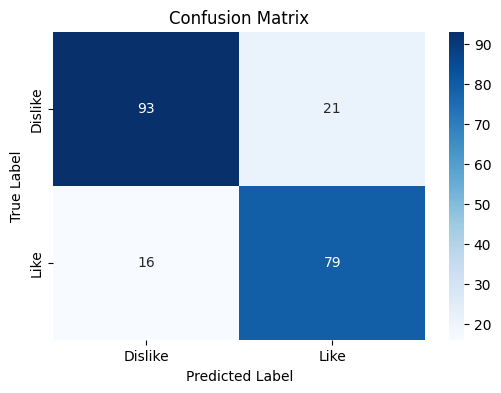

Accuracy of the SVM model: 0.8229665071770335
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.82      0.83       114
         1.0       0.79      0.83      0.81        95

    accuracy                           0.82       209
   macro avg       0.82      0.82      0.82       209
weighted avg       0.82      0.82      0.82       209



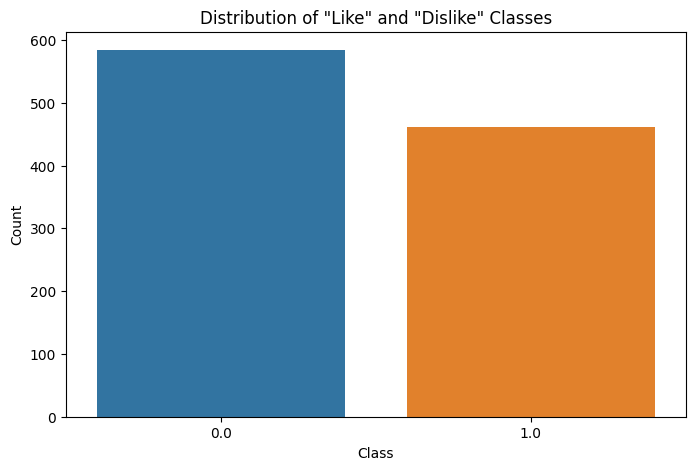

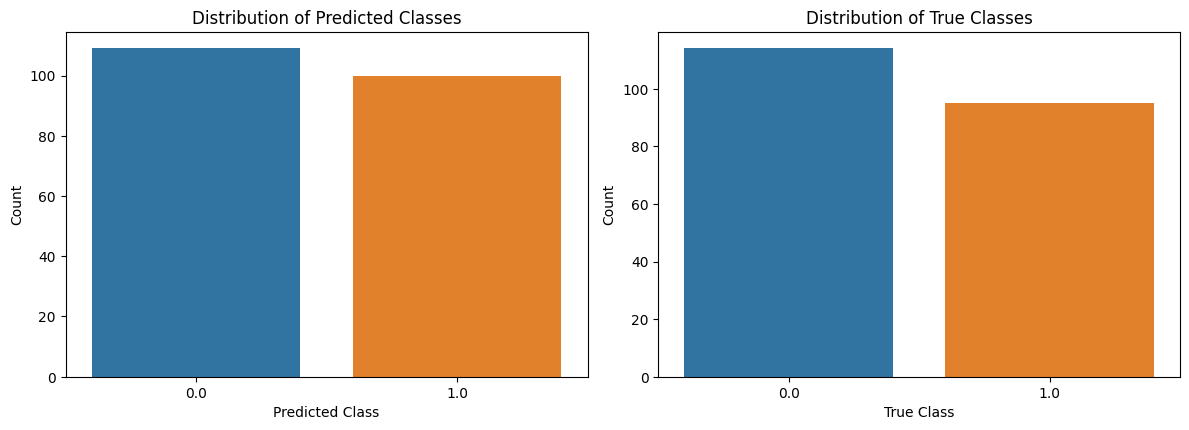

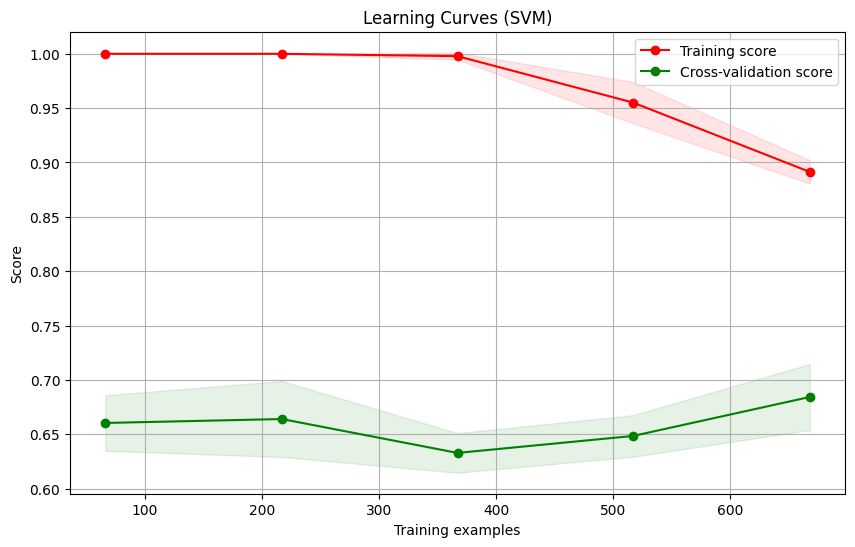

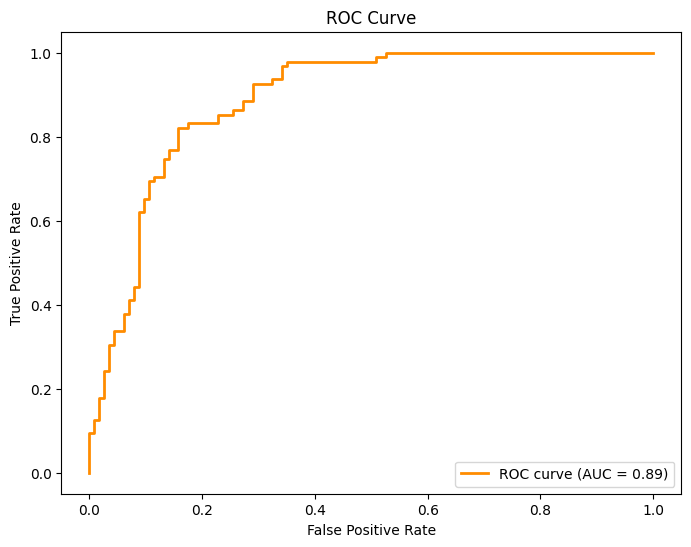

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(preprocessed_data[:, :-1], preprocessed_data[:, -1], test_size=0.2, random_state=42)

svm_model = SVC()

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Dislike', 'Like'], yticklabels=['Dislike', 'Like'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the SVM model:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

like_dislike_counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(8, 5))
sns.barplot(x=like_dislike_counts[0], y=like_dislike_counts[1])
plt.title('Distribution of "Like" and "Dislike" Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


plt.figure(figsize=(12, 8))

# Distribution of Predicted Classes
plt.subplot(2, 2, 1)
sns.barplot(x=np.unique(y_pred, return_counts=True)[0], y=np.unique(y_pred, return_counts=True)[1])
plt.title('Distribution of Predicted Classes')
plt.xlabel('Predicted Class')
plt.ylabel('Count')

# Distribution of True Classes
plt.subplot(2, 2, 2)
sns.barplot(x=np.unique(y_test, return_counts=True)[0], y=np.unique(y_test, return_counts=True)[1])
plt.title('Distribution of True Classes')
plt.xlabel('True Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Function to plot learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plotting learning curves
title = "Learning Curves (SVM)"
plot_learning_curve(logreg_model, title, X_train, y_train, cv=5, n_jobs=-1)
plt.show()

from sklearn.metrics import roc_curve, auc

y_prob = svm_model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Epoch 1/10
21/21 [==============================] - 2s 25ms/step - loss: 0.7318 - accuracy: 0.5120 - val_loss: 0.6805 - val_accuracy: 0.6190
Epoch 2/10
21/21 [==============================] - 0s 12ms/step - loss: 0.5077 - accuracy: 0.8084 - val_loss: 0.6446 - val_accuracy: 0.6786
Epoch 3/10
21/21 [==============================] - 0s 15ms/step - loss: 0.3837 - accuracy: 0.8967 - val_loss: 0.6380 - val_accuracy: 0.6845
Epoch 4/10
21/21 [==============================] - 0s 12ms/step - loss: 0.2902 - accuracy: 0.9237 - val_loss: 0.6446 - val_accuracy: 0.6845
Epoch 5/10
21/21 [==============================] - 0s 13ms/step - loss: 0.2177 - accuracy: 0.9356 - val_loss: 0.6648 - val_accuracy: 0.6905
Epoch 6/10
21/21 [==============================] - 0s 17ms/step - loss: 0.1636 - accuracy: 0.9566 - val_loss: 0.6925 - val_accuracy: 0.7262
Epoch 7/10
21/21 [==============================] - 0s 11ms/step - loss: 0.1207 - accuracy: 0.9701 - val_loss: 0.7349 - val_accuracy: 0.7262
Epoch 8/10
21

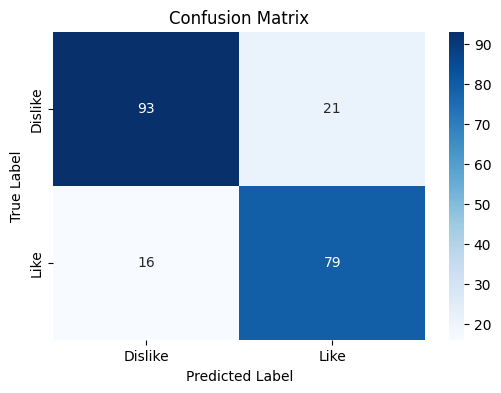

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.82      0.78       114
         1.0       0.76      0.66      0.71        95

    accuracy                           0.75       209
   macro avg       0.75      0.74      0.75       209
weighted avg       0.75      0.75      0.75       209



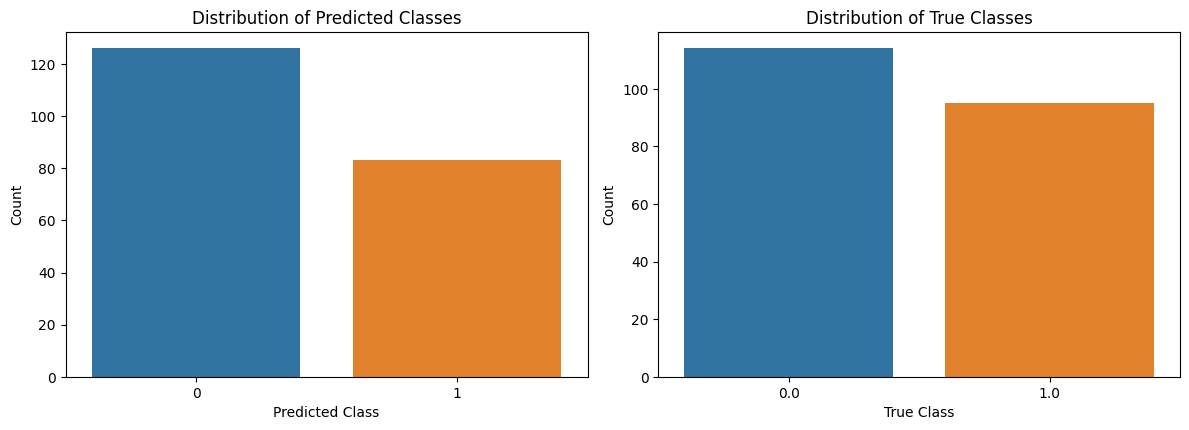

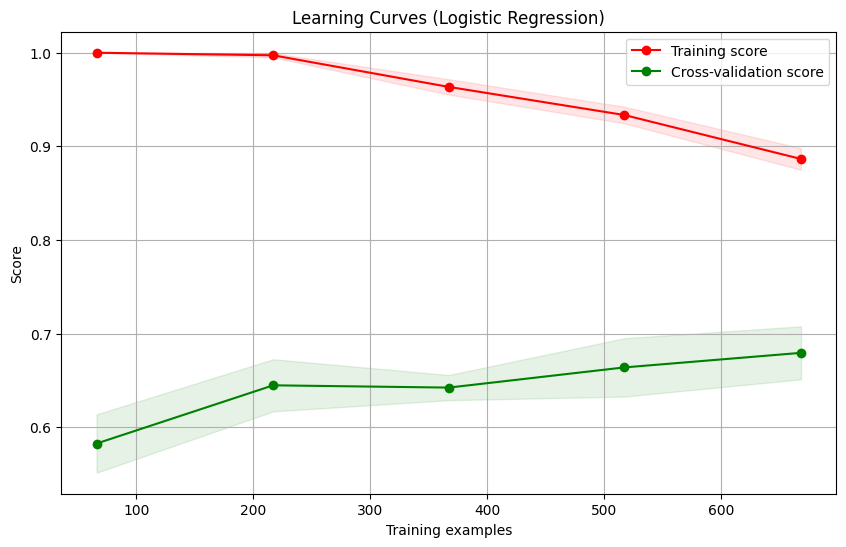

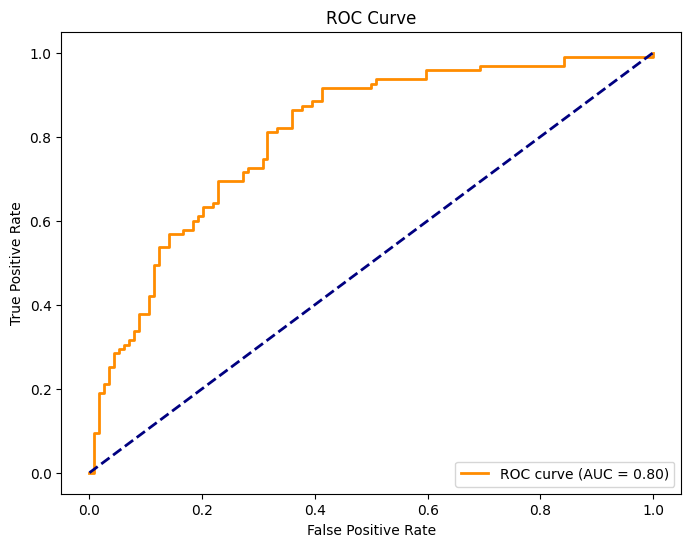

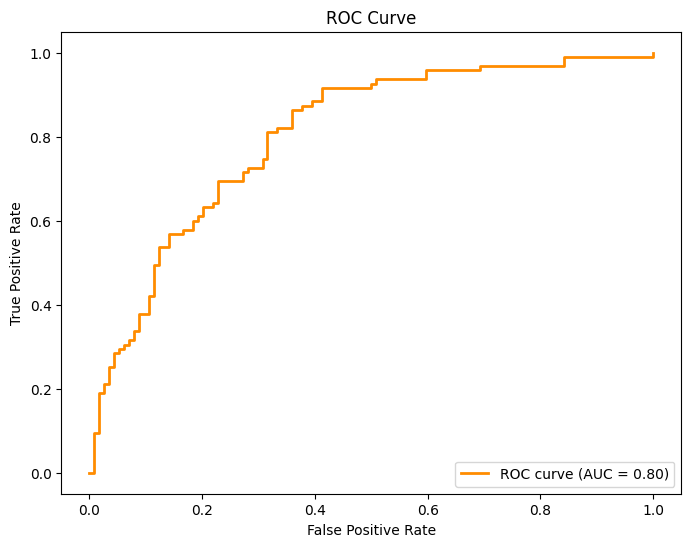

In [ ]:
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(preprocessed_data[:, :-1], preprocessed_data[:, -1], test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # For binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

y_pred = (model.predict(X_test) > 0.5).astype("int32")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Dislike', 'Like'], yticklabels=['Dislike', 'Like'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

plt.figure(figsize=(12, 8))


# Distribution of Predicted Classes
plt.subplot(2, 2, 1)
sns.barplot(x=np.unique(y_pred, return_counts=True)[0], y=np.unique(y_pred, return_counts=True)[1])
plt.title('Distribution of Predicted Classes')
plt.xlabel('Predicted Class')
plt.ylabel('Count')

# Distribution of True Classes
plt.subplot(2, 2, 2)
sns.barplot(x=np.unique(y_test, return_counts=True)[0], y=np.unique(y_test, return_counts=True)[1])
plt.title('Distribution of True Classes')
plt.xlabel('True Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Function to plot learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plotting learning curves
title = "Learning Curves (Logistic Regression)"
plot_learning_curve(logreg_model, title, X_train, y_train, cv=5, n_jobs=-1)
plt.show()

from sklearn.metrics import roc_curve, auc

y_prob = svm_model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

from sklearn.metrics import roc_curve, auc

y_prob = svm_model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()